In [1]:
## SIMULATION PARAMETERS
verbosity         = 5        # Set debug print statement verbosity level (0 = Standard, -1 = Off)
use_mass_units    = False     # Toggle whether calculations / results are given in units of pi-axion mass (True) or eV (False)
use_natural_units = True     # Toggle whether calculations / results are given in c = h = G = 1 (True) or SI units (False)   || NOTE: full SI/phsyical unit support is still WIP!!
save_output_files = True    # Toggle whether or not the results from this notebook run are written to a data directory

config_name = '3_neutrals'   # Descriptive name for the given parameter case. Output files will be saved in a directory with this name.
seed = None                  # rng_seed, integer value (None for random)
num_cores = 32               # Number of parallel threads available

In [2]:
import numpy as np
import pandas as pd
from collections import OrderedDict
from scipy.integrate import solve_ivp
from scipy.signal import spectrogram
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.image as image
import matplotlib.cm as cm
from piaxi_numerics import set_param_space, solve_system, define_masses
from piaxi_utils import *
import os
import json
import hashlib

debug_level = verbosity

In [3]:
data_path = '~/data/pi-axiverse-data'
version   = 'v2.6'

fixed_rng_seed = True
if seed != None:
    rng_ss = np.random.SeedSequence(entropy=seed, pool_size=num_cores)
elif fixed_rng_seed:
    rng_ss = np.random.SeedSequence(entropy=1, pool_size=num_cores)
else:
    rng_ss = np.random.SeedSequence(pool_size=num_cores)
rng_seed = rng_ss.entropy
rng = np.random.default_rng(rng_ss)

if debug_level > 3:
    print('rng_seed:', rng_seed)

rng_seed: 1


In [4]:
# Unitful fundamental constants
c_raw = c = np.float64(2.998e10)    # Speed of light in a vacuum [cm/s]
h_raw = h = np.float64(4.136e-15)   # Planck's constant [eV/Hz]
G_raw = G = np.float64(1.0693e-19)  # Newtonian constant [cm^5 /(eV s^4)]
manual_set = False
if manual_set: # Manually toggle units
    unitful_c = False
    unitful_h = False
    unitful_G = False
if use_natural_units:
    unitful_c = unitful_h = unitful_G = False
else:
    unitful_c = unitful_h = unitful_G = True

# values to use in calculations in order to ensure correct units
c_u = c if unitful_c else 1.
h_u = h if unitful_h else 1.
G_u = G if unitful_G else 1.

In [5]:
# Set constants of model
e    = 0.3      # dimensionless electron charge
#F    = 1e16     # pi-axion decay constant (GeV) >= 10^11
F = 1e9
#p_t  = 0.4     # total local DM density (GeV/cm^3)
p_t = 1e20
#p_unit = 1.906e-12
p_unit = (c_raw*h_raw)**3 if use_natural_units else (c_u*h_u)**3   # convert densities from units of [1/cm^3] to [eV^3]
## --> TODO: Could/Should we support spatially dependent distributions?

## Tuneable constants
# millicharge, vary to enable/disable charged species (10e-15 = OFF, 10e-25 = ON)
#eps  = 1e-25   # (unitless)
eps  = 1

# Coupling constants
#L3   = 1e11    # (GeV)
L3   = 1e11
#L4   = 1e11    # (GeV)
L4   = 1e11
l1   = 1       #
l2   = 1       #
l3   = 1       #
l4   = 1       #

# Unit scaling:
GeV  = 1e9     # GeV -> eV
#GeV = 1
F   *= GeV
p_t *= GeV
p_t *= p_unit  # 1/cm^3 -> (eV/hc)^3
L3  *= GeV
L4  *= GeV

In [6]:
## Dark SM Parameters
sample_qmass = False # TODO
sample_qcons = False
# Mass scaling parameters
m_scale = 1e-22             # dark quark mass scale (eV) <= 10-20

# SM quark masses for all 3 generations
qm = m_scale*np.array([1., 2., 40.]) if not sample_qmass else m_scale*np.array([0., 0., 0.]) # TODO

# dSM quark scaling constants (up, down, strange, charm, bottom, top) sampled from uniform distribution [0.7, 1.3]
qc = np.array([1., 1., 1., 0., 0., 0.]) if not sample_qcons else rng.uniform(0.7, 1.3, (6,))
#qc = np.array([1., 1., 1., 1., 1., 1.]) if not sample_qcons else rng.uniform(0.7, 1.3, (6,))

# Dark quark masses (up, down, strange, charm, bottom, top)
dqm = np.array([qm[0]*qc[0], qm[0]*qc[1], qm[1]*qc[2], qm[1]*qc[3], qm[2]*qc[4], qm[2]*qc[5]])

# Scaling parameters
xi     = np.array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])  # Charged species scaling paramters
eps_c  = np.array([+1., +1., +1., -1., -1., -1., -1., +1., -1.])  # Millicharge sign

In [7]:
# Initial Conditions
A_0    = 0.1
Adot_0 = 0.0
A_pm   = +1       # specify A± case (+1 or -1)
A_sens = 1.0      # sensitivity for classification of resonance conditions

In [8]:
# Time domain
t_span = [0, 300]   # Units of 1/m_u
#t_N    = 300       # Number of timesteps
t_N = 100
t_sens = 0.1       # sensitivity for calculating time-averaged values

# k values
use_k_eq_0 = False     # Toggle whether or not k = 0 is included in the numerics (div. by 0 error possible if on)
k_min = 0 if use_k_eq_0 else 1
k_max = 20
k_span = [k_min, k_max]  # TODO: replace with the appropriate values
k_res = 1                            # k-mode granularity
k_N = int((1./k_res)*max((k_max - k_min), 0) + 1)    # Number of k-modes

In [9]:
## Parameters of model
manual_set = False       # Toggle override mass definitions
unitful_masses = True    # Toggle whether to provide unitful [eV] masses vs. mass-ratio [m_unit] values for calculations (Default: True)
unitful_k = False        # Toggle whether k values are defined unitfully [eV] vs. units of mass-ratio [m_unit] (Default: False)

## Define pi-axiverse masses
m_r, m_n, m_c, counts, masks = define_masses(qm=qm, qc=qc, F=F, e=e, eps=eps, eps_c=eps_c, xi=xi)
N_r, N_n, N_c = counts
m_unit = np.min([np.min(m_i) for m_i in (m_r.compressed(), m_n.compressed(), m_c.compressed()) if len(m_i) > 0])

## masses for real, complex, and charged species (given in units of eV)
if manual_set:               # Override (for testing purposes)
    m_scale = 1e-8 if unitful_masses else 1.
    m_r = np.array([1.])*m_scale
    m_n = np.array([3.])*m_scale
    m_c = np.array([5.])*m_scale
    m = np.array([m_r, m_n, m_c], dtype=object, copy=True)
    m_raw = m
else:
    m = np.array([m_r.compressed(), m_n.compressed(), m_c.compressed()], dtype=object, copy=True)
    m_raw = m
    m *= (1. if unitful_masses else 1./m_unit) # Ensure m is provided in desired units
    if unitful_masses and not use_natural_units: 
        m      *= (1./c**2) # WIP
        m_unit *= (1./c**2)
        
# Turn off irrelevant constants
if N_r <= 0 and N_n <= 0:
    L4 = -1                   # Turn off Lambda_4 if there are no surviving neutral (real and complex) species
if N_c <= 0:
    L3 = -1                   # Turn off Lambda_3 if there are no surviving charged species


## local DM densities for each species, assume equal mix for now.
# TODO: More granular / nontrivial distribution of densities? Spacial dependence? Sampling?
norm_subdens = True
if norm_subdens:
    p_loc = p_t/3.
else:
    p_loc = p_t

## Override (for testing purposes)
if manual_set:
    p_r = np.array([1./max(1., N_r)])
    p_n = np.array([1./max(1., N_n), 1./max(1., N_n)])
    p_c = np.array([0.])
    #p_r = np.array([1.])
    #p_n = np.array([1.])
    #p_c = np.array([1.])
    
    p = np.array([p_r*p_loc, p_n*p_loc, p_c*p_loc], dtype=object)
else:
    p_r  = np.ma.masked_where(masks[0], np.full_like(m_r, 1./max(1., N_r), dtype=float), copy=True)
    p_n  = np.ma.masked_where(masks[1], np.full_like(m_n, 1./max(1., N_n), dtype=float), copy=True)
    p_c  = np.ma.masked_where(masks[2], np.full_like(m_c, 1./max(1., N_c), dtype=float), copy=True)
    np.ma.set_fill_value(p_r, 0.0)
    np.ma.set_fill_value(p_n, 0.0)
    np.ma.set_fill_value(p_c, 0.0)

    p = np.array([p_r.compressed()*p_loc, p_n.compressed()*p_loc, p_c.compressed()*p_loc], dtype=object, copy=True)

## initial (local) DM amplitudes for each species, optional units of [eV/c]
amps = np.array([np.array([np.sqrt(2 * p[s][i]) / m[s][i] if np.abs(m[s][i]) > 0. else 0. for i in range(len(m[s]))], dtype=float) for s in range(len(m))], dtype=object, copy=True)
amps_raw = np.copy(amps)
# normalize/rescale amplitudes by dividing by amp of pi_0?
unitful_amps = unitful_masses  # Assume amplitudes given are in units of [eV] if masses are as well (otherwise eV^2/m_unit)
rescale_amps = use_mass_units if unitful_amps else not(use_mass_units)
amps_to_units = np.sqrt((h/c)**3) # (TODO: WIP, double check these units)
if rescale_amps:
    if unitful_amps:
        amps *= (1. / m_unit)          # convert to units of [m_unit] instead of [eV]
    else:
        amps *= m_unit                 # convert to units of [eV] instead of [m_unit]
        if not(use_natural_units):
            amps *= amps_to_units
else:
    if unitful_amps and not(use_natural_units):
        amps *= amps_to_units

## local phases for each species (to be sampled)
d        = np.array([np.zeros_like(m[0], dtype=float), np.zeros_like(m[1], dtype=float), np.zeros_like(m[2], dtype=float)], dtype=object)   # (0, 2pi)
d_sample = True

## global phase for neutral complex species (to be sampled)
Th        = np.array([np.zeros_like(m[0], dtype=float), np.zeros_like(m[1], dtype=float), np.zeros_like(m[2], dtype=float)], dtype=object)   # (0, 2pi)
Th_sample = True

if debug_level > 2:
    print('m_unit:  ', m_unit)
    if debug_level > 3:
        print('m (raw):\n', m_raw)
        print('m (out):\n', m)
    else:
        print('m:\n', m)
    if debug_level > 3:
        print('amps (raw):\n', amps_raw)
        print('amps (out):\n', amps)
    else:
        print('amps:\n', amps)

#trim_masked_arrays = lambda arr: np.ma.masked_where(len(arr) <= 0, arr)
trim_masked_arrays = lambda arr: np.array([np.array(arr_i, dtype=float) if len(arr_i) > 0 else np.array([], dtype=float) for arr_i in arr], dtype=object)
m    = trim_masked_arrays(m)
p    = trim_masked_arrays(p)
amps = trim_masked_arrays(amps)
Th   = trim_masked_arrays(Th)
d    = trim_masked_arrays(d)

m_unit:   0.01414213562373095
m (raw):
 [array([0.01414214, 0.02      ]) array([0.01732051])
 array([], dtype=float64)]
m (out):
 [array([0.01414214, 0.02      ]) array([0.01732051])
 array([], dtype=float64)]
amps (raw):
 [array([1.78255366e+10, 1.26045578e+10]) array([2.05831567e+10])
 array([], dtype=float64)]
amps (out):
 [array([1.78255366e+10, 1.26045578e+10]) array([2.05831567e+10])
 array([], dtype=float64)]


In [10]:
# Sample phases from normal distribution, between 0 and 2pi
cosine_form = True
mu  = np.pi      # mean
sig = np.pi / 3  # standard deviation

# Modulo 2pi to ensure value is within range
shift_val = np.pi if cosine_form else 0.
if d_sample:
        #d  = np.array([np.ma.masked_where(masks[i], np.mod(rng.normal(mu, sig, len(d_i)), 2*np.pi)).compressed() for i,d_i in enumerate(d)], dtype=object)
        d  = np.array([np.mod(rng.normal(mu, sig, len(d_i)) + shift_val, 2*np.pi) for i,d_i in enumerate(d)], dtype=object)
if Th_sample:
        #Th = np.array([np.ma.masked_where(masks[i], np.mod(rng.normal(mu, sig, len(Th_i)), 2*np.pi)).compressed() for i,Th_i in enumerate(Th)], dtype=object)
        Th = np.array([np.mod(rng.normal(mu, sig, len(Th_i)) + shift_val, 2*np.pi) for i,Th_i in enumerate(Th)], dtype=object)

In [11]:
## Define the system of ODEs
# TODO: Finish defining time-dependent functions P(t), B(t), C(t), D(t) here
#       - Verify they are the correct form, double check all signs and factors of 2
# NOTE: Using cosine definitons for amplitudes
#       i = {0,1,2} correspond to {pi_0, pi, pi_±} respectively

# Toggle whether mass-energy values should be computed in units of eV (False) or pi-axion mass (True)
# (by default, k is defined in units of [m_u] whereas m is defined in units of [eV], so their scaling logic is inverted)
rescale_m      = use_mass_units if unitful_masses else not(use_mass_units)
rescale_k      = not(rescale_m) if unitful_masses else rescale_m
m0 = 1. if not rescale_m else (1./m_unit if unitful_masses else m_unit)         # [m_u] <--> [eV]
k0 = m_unit if rescale_k else 1.

# Rescale all eV unit constants to unit mass
#rescale_consts = False
rescale_consts = rescale_m if unitful_masses else not(rescale_m)
L3_sc = abs(L3) if not rescale_consts or L3 < 0 else L3 / m_unit
L4_sc = abs(L4) if not rescale_consts or L4 < 0 else L4 / m_unit
F_sc  = abs(F)  if not rescale_consts or F < 0  else  F / m_unit

# Shorthand helper function for oscillatory time-dependent terms
# (time is assumed to be given in units of [1/m_u])
phi = lambda t, s, i, m=m, d=d, M=(1./m_unit if unitful_masses else 1.): (m[s][i]*M)*t + d[s][i]
#phi = lambda t, s, i, m=m, d=d, M=(1./m_unit if unitful_masses and not rescale_m else 1.): (m[s][i]*M)*t + d[s][i]

units = {'c': 1 if not unitful_c else 'cm/s', 'h': 1 if not unitful_h else 'eV/Hz', 'G': 1 if not unitful_G else 'cm^5/(eV s^4)', 
         'm': 'm_u' if not((unitful_masses and not rescale_m) or (not unitful_masses and rescale_m)) else 'eV/c^2' if unitful_c else 'eV',
         'k': 'm_u' if not rescale_k else 'eV/c' if unitful_c else 'eV',
         'p': 'eV/cm^3' if p_unit == 1. else 'eV^4' if not(unitful_c or unitful_h) else 'eV^4/(hc)^3',
         'amp': 'm_u' if (rescale_amps and unitful_amps) else 'eV^2/m_u^2' if (rescale_amps and not unitful_amps) else 'eV' if unitful_amps and use_natural_units else 'eV/c', # 'eV (h^3 c)^(-1/2)'
         'Lambda': 'm_u' if rescale_consts else 'eV/c^2' if unitful_c else 'eV',
         'lambda': 1,
         'F': 1 if F < 0 else 'm_u' if rescale_consts else 'eV/c^2' if unitful_c else 'eV',
         't': '1/m_u',
         'Theta': 'π',
         'delta': 'π'}

pp_param = lambda p, p_u=1., n=2, pfx='  ', notn='e': str(pfx)+('\n'+str(pfx)).join(['m_(%s): %s' % (s_label, ' | '.join([('%.'+('%d' % n)+str(notn)) % (p_s_i*p_u) for p_s_i in p_s]) if len(p_s) > 0 else 'N/A') for p_s, s_label in zip(p, ['0','π','±'])])
if debug_level > 2:
    print('use_mass_units: %5s' % str(use_mass_units), '||', 'use_natural_units:', use_natural_units)
    if debug_level > 3 and not use_natural_units:
        for c_sw, c_name, c_val in zip([unitful_c, unitful_h, unitful_G], ['c', 'h', 'G'], [c, h, G]):
            print('unitful_'+c_name+':', c_sw, '      | ', c_name+' =', str(1 if units[c_name] == 1 else '%.3e [%s]' % (c_val, units[c_name])))
    print('----------------------------------------------------')
if debug_level > 3:
    print('unitful_masses:', '%5s' % str(unitful_masses), '| [m_u]' if not unitful_masses else '| [%s]' % 'eV')
    print('rescale_m:     ', '%5s' % str(rescale_m),      ''        if not rescale_m else '| [%s] -> [%s]' % (('eV','m_u') if unitful_masses else ('m_u','eV')))
    print('unitful_k:     ', '%5s' % str(unitful_k),      '| [m_u]' if not unitful_k else '| [%s]' % 'eV')
    print('rescale_k:     ', '%5s' % str(rescale_k),      ''        if not rescale_k else '| [%s] -> [%s]' % (('eV','m_u') if unitful_k      else ('m_u','eV')))
    print('unitful_amps:  ', '%5s' % str(unitful_amps),   '| [eV]'  if unitful_amps  else '| [eV^2/m_u]')
    print('rescale_amps:  ', '%5s' % str(rescale_amps),   '' if not rescale_amps     else '| [%s] -> [%s]' % (('eV','m_u') if unitful_amps   else ('eV^2/m_u','eV^2/m_u^2')))
    print('rescale_consts:', '%5s' % str(rescale_consts), '' if not rescale_consts   else '| [%s] -> [%s]' % (('eV','m_u') if unitful_masses else ('eV', 'eV/m_u')))
    print('----------------------------------------------------')
if debug_level >= 0:
    print('m_dQCD = %.0e [eV%s]' % (m_scale, '' if use_natural_units else '/c^2'))
    if units['m'] == 'm_u': print('m_u = %.3e [eV%s]' % (m_unit, '' if use_natural_units else '/c^2'))
    print('m [' + units['m'] + ']\n'      + pp_param(m, m0, 3))
    print('rho [' + units['p'] + ']\n'    + pp_param(p, n=3))
    print('amp [' + units['amp'] + ']\n'  + pp_param(amps, n=3))
    print('Theta [π]\n'                   + pp_param(Th, 1. / np.pi, 2, notn='f'))
    print('delta [π]\n'                   + pp_param(d,  1. / np.pi, 2, notn='f'))
    
# Define functions to clean up differential equation representation
P = lambda t, l3=l3, L3=L3_sc, l4=l4, L4=L4_sc, eps=eps, amps=amps, m=m, M=m0, d=d, Th=Th, c=c_u, h=h_u, G=G_u, phi=phi, np=np: \
            2*l3/(L3**2) * eps**2 * (np.sum([amps[2][i]*amps[2][j]/c**2 * np.cos(phi(t,2,i))*np.cos(phi(t,2,j)) * np.cos(Th[2][i]-Th[2][j]) \
                                             for i in range(len(m[2])) for j in range(len(m[2]))], axis=0)) + \
            2*l4/(L4**2) * eps**2 * (np.sum([amps[1][i]*amps[1][j]/c**2 * np.cos(phi(t,1,i))*np.cos(phi(t,1,j)) * np.cos(Th[1][i]-Th[1][j]) \
                                             for i in range(len(m[1])) for j in range(len(m[1]))], axis=0) + \
                                            np.sum([amps[0][i]*amps[0][j]/c**2 * np.cos(phi(t,0,i))*np.cos(phi(t,0,j)) \
                                             for i in range(len(m[0])) for j in range(len(m[0]))], axis=0) + \
                                          2*np.sum([amps[0][i]*amps[1][j]/c**2 * np.cos(phi(t,0,i))*np.cos(phi(t,1,j)) * np.cos(Th[1][j]) \
                                             for i in range(len(m[0])) for j in range(len(m[1]))], axis=0))

B = lambda t, l3=l3, L3=L3_sc, l4=l4, L4=L4_sc, eps=eps, amps=amps, m=m, M=m0, d=d, Th=Th, c=c_u, h=h_u, G=G_u, phi=phi, np=np: \
            (-1)*2*l3/(L3**2) * eps**2 * (np.sum([amps[2][i]*amps[2][j]/c**2 * np.cos(Th[2][i]-Th[2][j])  * \
                                                  ((m[2][i]*M/c**2) * np.sin(phi(t,2,i)) * np.cos(phi(t,2,j)) + \
                                                   (m[2][j]*M/c**2) * np.cos(phi(t,2,i)) * np.sin(phi(t,2,j))) \
                                                  for i in range(len(m[2])) for j in range(len(m[2]))], axis=0)) + \
            (-1)*2*l4/(L4**2) * eps**2 * (np.sum([amps[0][i]*amps[0][j]/c**2 * ((m[0][i]*M/c**2) * np.sin(phi(t,0,i)) * np.cos(phi(t,0,j)) + \
                                                                                  (m[0][j]*M/c**2) * np.cos(phi(t,0,i)) * np.sin(phi(t,0,j))) \
                                                  for i in range(len(m[0])) for j in range(len(m[0]))], axis=0) + \
                                                 np.sum([amps[1][i]*amps[1][j]/c**2 * np.cos(Th[1][i]-Th[1][j])  * \
                                                         ((m[1][i]*M/c**2) * np.sin(phi(t,1,i)) * np.cos(phi(t,1,j)) + \
                                                          (m[1][j]*M/c**2) * np.cos(phi(t,1,i)) * np.sin(phi(t,1,j))) \
                                                         for i in range(len(m[1])) for j in range(len(m[1]))], axis=0) + \
                                                 np.sum([np.abs(amps[0][i]*amps[1][j]/c**2) * np.cos(Th[1][j]) * \
                                                         ((m[0][i]*M/c**2) * np.sin(phi(t,0,i)) * np.cos(phi(t,1,j)) + \
                                                          (m[1][j]*M/c**2) * np.cos(phi(t,0,i)) * np.sin(phi(t,1,j))) \
                                                         for i in range(len(m[0])) for j in range(len(m[1]))], axis=0))

C = lambda t, pm, l1=l1, F=F_sc, eps=eps, amps=amps, m=m, M=m0, d=d, c=c_u, h=h_u, G=G_u, phi=phi, np=np: \
            (-1) * pm * (2*l1 / F) * eps**2 * np.sum([amps[0][i]/c**2 * (m[0][i]*M/c**2) * np.sin(phi(t,0,i)) \
                                                      for i in range(len(m[0]))], axis=0)

D = lambda t, l2=l2, e=e, eps=eps, amps=amps, m=m, M=m0, d=d, Th=Th, c=c_u, h=h_u, G=G_u, phi=phi, np=np: \
            l2 * eps**2 * e**2 * np.sum([amps[2][i]*amps[2][j]/c**2 * np.cos(phi(t,2,i))*np.cos(phi(t,2,j)) * np.cos(Th[2][i]-Th[2][j]) \
                                         for i in range(len(m[2])) for j in range(len(m[2]))], axis=0)

override_coefficients = False
if override_coefficients:
    #P = lambda t: np.float64(0)
    #B = lambda t: np.float64(0)
    #D = lambda t: np.float64(0)
    #C = lambda t, pm: np.float64(0)
    override_coefficients = True
    
def local_system(t, y, k, params, P=P, B=B, C=C, D=D, A_pm=A_pm, bg=1, k0=k0, c=c_u, h=h_u, G=G_u, ):
    # System of differential equations to be solved (bg = photon background)
    dy0dt = y[1]
    dy1dt = -1./(bg + P(t)) * (B(t)*y[1] + (C(t, A_pm)*(k*k0) + D(t))*y[0]) - (k*k0)**2*y[0]
    return [dy0dt, dy1dt]

use_mass_units: False || use_natural_units: True
----------------------------------------------------
unitful_masses:  True | [eV]
rescale_m:      False 
unitful_k:      False | [m_u]
rescale_k:       True | [m_u] -> [eV]
unitful_amps:    True | [eV]
rescale_amps:   False 
rescale_consts: False 
----------------------------------------------------
m_dQCD = 1e-22 [eV]
m [eV]
  m_(0): 1.414e-02 | 2.000e-02
  m_(π): 1.732e-02
  m_(±): N/A
rho [eV^4]
  m_(0): 3.177e+16 | 3.177e+16
  m_(π): 6.355e+16
  m_(±): N/A
amp [eV]
  m_(0): 1.783e+10 | 1.260e+10
  m_(π): 2.058e+10
  m_(±): N/A
Theta [π]
  m_(0): 1.70 | 0.27
  m_(π): 0.47
  m_(±): N/A
delta [π]
  m_(0): 1.76 | 0.23
  m_(π): 1.94
  m_(±): N/A


In [12]:
# Prepare the numerical integration
k_values, k_step = np.linspace(k_span[0], k_span[1], k_N, retstep=True)
#k_values = np.linspace(1./100, 10, 100)

# Initialize an array to store the solutions
t, t_step = np.linspace(t_span[0], t_span[1], t_N, retstep=True)  # Array of times at which to evaluate, t > 0
#t = t[1:]

# Classification sensitivity threshold
res_con = 1000
#res_con = max(100,1./A_sens)

# Collect all input parameters
parameters = {'e': e, 'F': F, 'p_t': p_t, 'eps': eps, 'L3': L3, 'L4': L4, 'l1': l1, 'l2': l2, 'l3': l3, 'l4': l4, 'res_con': res_con,
              'A_0': A_0, 'Adot_0': Adot_0, 'A_pm': A_pm, 't_sens': t_sens, 'A_sens': A_sens,
              'qm': qm, 'qc': qc, 'dqm': dqm, 'eps_c': eps_c, 'xi': xi, 'm_0': m0, 'm_u': m_unit, 'm_scale': m_scale, 'p_unit': p_unit,
              'm_r': m[0], 'm_n': m[1], 'm_c': m[2], 'p_r': p[0], 'p_n': p[1], 'p_c': p[2], 'Th_r': Th[0], 'Th_n': Th[1], 'Th_c': Th[2],
              'amp_r': amps[0], 'amp_n': amps[1], 'amp_c': amps[2], 'd_r': d[0], 'd_n': d[1], 'd_c': d[2], 'k_0': k0,
              'unitful_m': unitful_masses, 'rescale_m': rescale_m, 'unitful_amps': unitful_amps, 'rescale_amps': rescale_amps, 
              'unitful_k': unitful_k, 'rescale_k': rescale_k, 'rescale_consts': rescale_consts, 'h': h, 'c': c, 'G': G, 'seed': rng_seed}

phash = get_parameter_space_hash(parameters)

if debug_level > 5:
    for key, val in parameters.items():
        print('%15s' % key, ':', val)
    print ('\n')
if debug_level > 3:
    print('parameter space configuration hash:')
    print(phash)

parameter space configuration hash:
c2cbe8aba291239f8602f532e6f0b52a4e3c15a1


In [13]:
# Solve the system, in parallel for each k-mode
os.environ['NUMEXPR_MAX_THREADS'] = '%d' % (max(int(num_cores), 1))
params = set_param_space(init_params(parameters, t_min=t_span[0], t_max=t_span[1], t_N=t_N, k_min=k_span[0], k_max=k_span[1], k_N=k_N))
solutions, params, time_elapsed, timestr = solve_system(local_system, jupyter=True, parallelize=True, num_cores=num_cores)
result_plots = {}
print(timestr)

0:00:00.655853 on 32 cores


max (peak) k mode: 4.0
max (mean) k mode: 1.0


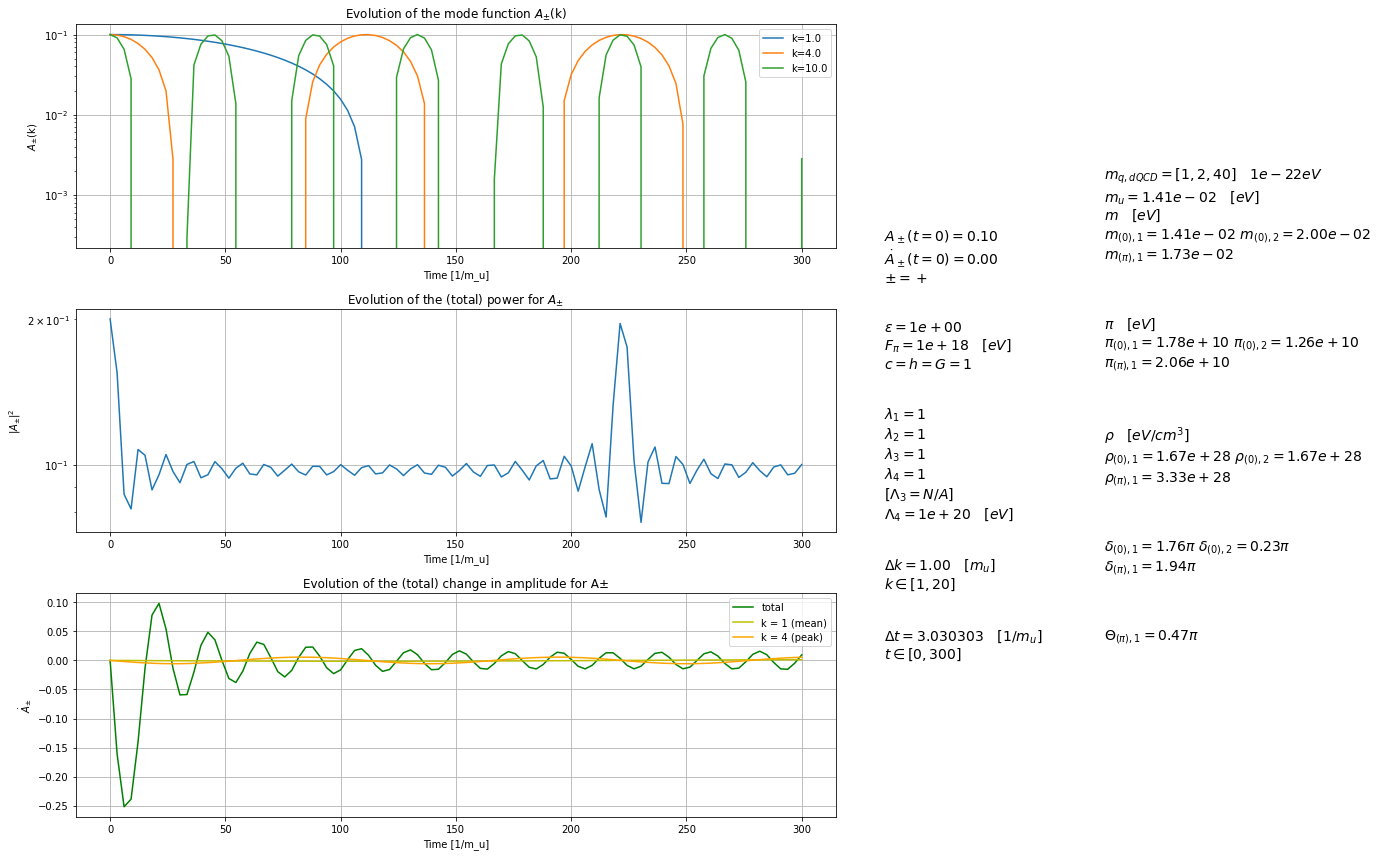

In [14]:
# Plot results (Amplitudes)
k_peak, k_mean = get_peak_k_modes(solutions)

if debug_level > 0:
    print('max (peak) k mode: ' + str(k_peak))
    print('max (mean) k mode: ' + str(k_mean))

# Plot the solution
plt = make_amplitudes_plot(params, units, solutions)
result_plots['amps'] = plt.gcf()
plt.show()

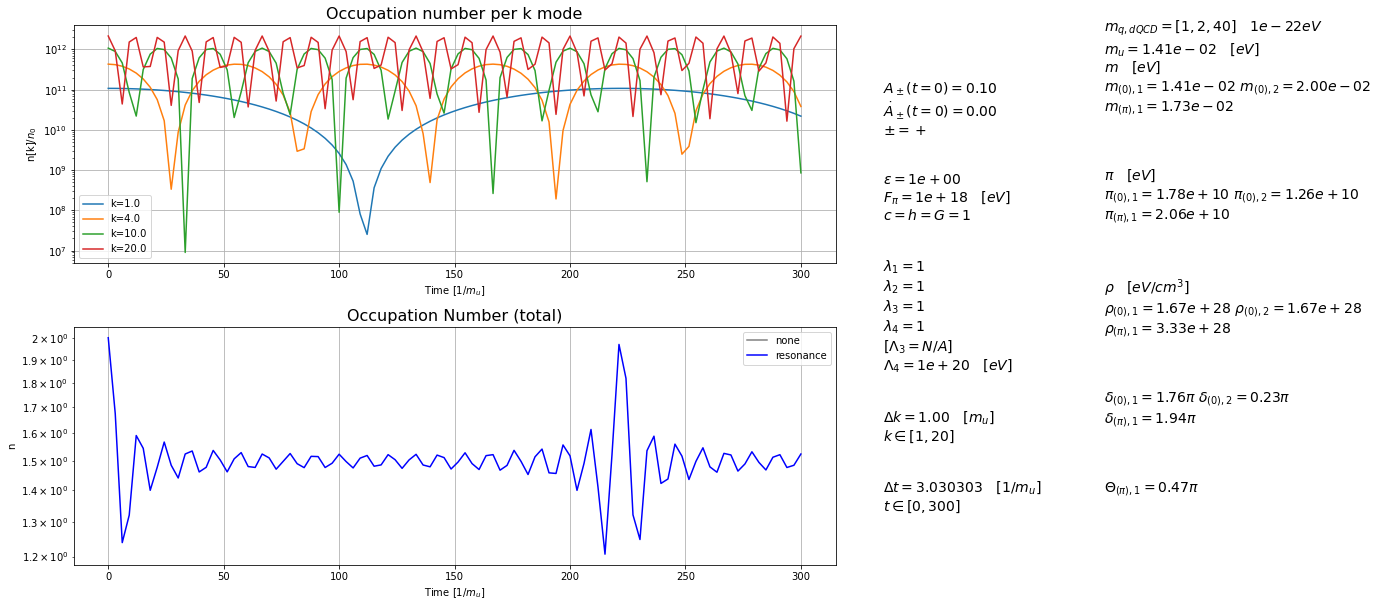

n_tot in range [4.66e+12, 2.26e+13]


In [15]:
# Plot the occupation numbers (TODO: Verify units in below equation)
#k_to_w = np.float64(4.555e25) # 2πc/hbar [(Hz/eV)*(cm/s)]
w = lambda i, k_u=m_unit, c=c_raw, h=h_raw: np.abs(k_values[i]*k_u*(2*np.pi/h))
n = lambda i, w, solns: (w(i)/2) * (((np.square(np.abs(solns[i][1])))/(np.square(w(i)))) + np.square(np.abs(solns[i][0]))) - (1/2)
times = t

scale_n = True
plt, params = make_occupation_num_plots(params, units, solutions, numf=n, omega=w, scale_n=scale_n)
n_tot = sum_n_k(n, w, solutions, times)
tot_res = params['res_class']
result_plots['nums'] = plt.gcf()
plt.show()

print('n_tot in range [%.2e, %.2e]' % (min(n_tot), max(n_tot)))
if 'res' in tot_res and debug_level > 2:
    print('resonance classification begins at t = %.2f, n = %.2e' % (t_res, n_res))

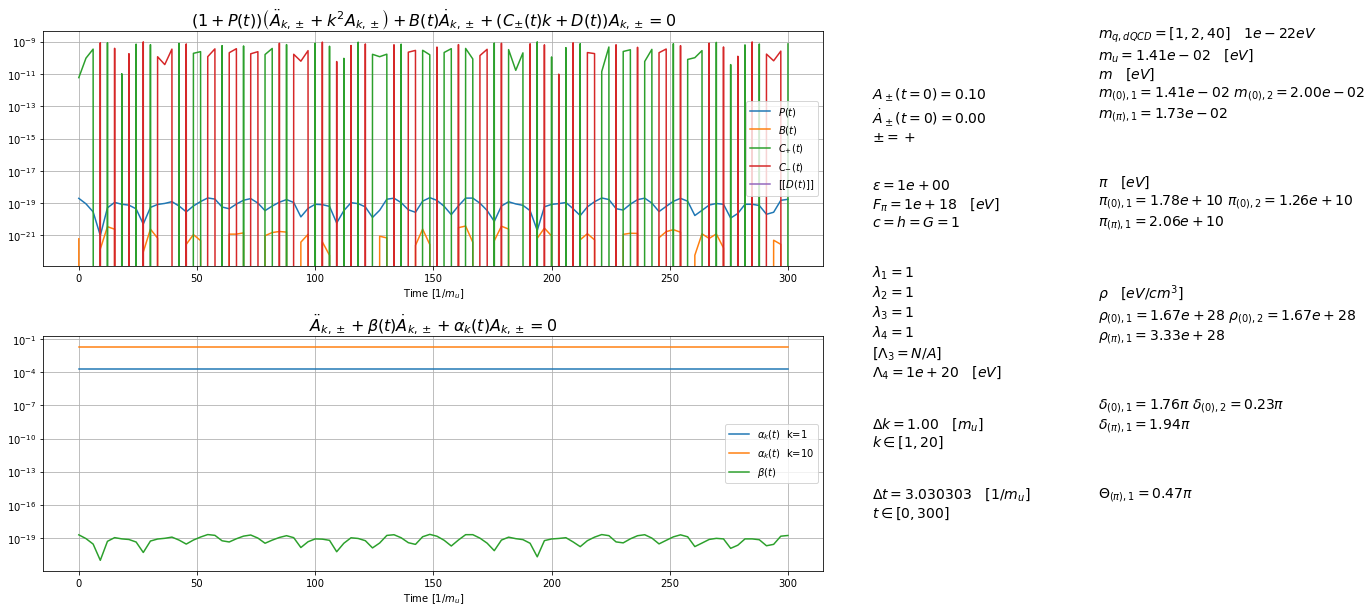

P(t) range: [9.9e-22, 2.2e-19]
B(t) range: [-3.9e-21, 3.8e-21]
C(t) range: [-1.0e-09, 1.0e-09] for + case 
C(t) range: [-1.0e-09, 1.0e-09] for - case 
D(t) range: [nan, nan]
------------------------------------------------------
Alpha(t,k) range: [2.0e-04, 2.0e-04] when k = 1
Alpha(t,k) range: [3.2e-03, 3.2e-03] when k = 4
Alpha(t,k) range: [2.0e-02, 2.0e-02] when k = 10
Alpha(t,k) range: [8.0e-02, 8.0e-02] when k = 20
Beta(t)    range: [9.9e-22, 2.2e-19]


In [16]:
# Plot results (Oscillating coefficient values)
plt = make_coefficients_plot(params, units, P, B, C, D, A_pm, k0)
result_plots['coeffs'] = plt.gcf()
plt.show()

if debug_level == 2:
    print_coefficient_ranges(P, B, C, D)
elif debug_level > 2:
    print_coefficient_ranges(P, B, C, D, print_all=True)

params['class']:
 none


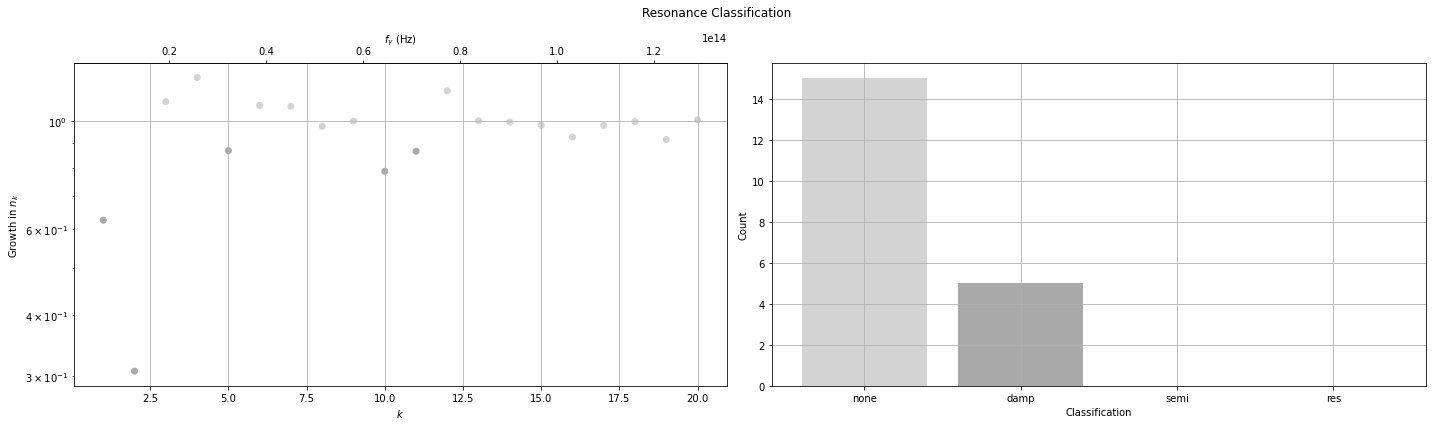

In [17]:
if debug_level > 5:
    print('params:\n', params, '\n')
if debug_level > 2:
    print('params[\'class\']:\n', params['class'])
    if debug_level > 6:
        print('params[\'k_class_arr\']:\n', params['k_class_arr'])
        print('k_ratio:\n', k_ratio(np.mean, t_sens, A_sens))

# E^2 = p^2c^2 + m^2c^4
# Assuming k, m are given in units of eV/c and eV/c^2 respectively
#k_to_Hz = lambda ki, mi=0, m_0=m0, e=e: 1/h * np.sqrt((ki*k0*e)**2 + ((mi*m_0 * e))**2)
k_to_Hz = lambda ki, k0=m_unit, h=h, c=c, e=e: ki * ((k0*e*2*np.pi) / h)
#Hz_to_k = lambda fi, mi=0, m_0=m0, e=e: 1/(e*k0) * np.sqrt((h * fi)**2 - ((mi*m_0 * e))**2)
Hz_to_k = lambda fi, k0=m_unit, h=h, c=c, e=e: fi * (h / (k0*e*2*np.pi))

# Plot k-mode power spectrum (TODO: Verify power spectrum calculation)
plt = make_resonance_spectrum(params, units, k_to_Hz, Hz_to_k)
result_plots['resonance'] = plt.gcf()
plt.show()

# Known observable frequency ranges (Hz)
FRB_range = [100e6, 5000e6]
GRB_range = [3e19, 3e21]

Hz_label = lambda f, pd=pd: pd.cut([f],
                                   [0, 300e6, 3e12, 480e12, 750e12, 30e15, 30e18, np.inf],
                                   labels=['Radio', 'Microwave', 'Infrared', 'Visible', 'UV', 'X-ray', 'Gamma ray'])

if 'res' in tot_res and debug_level >= 0:
    Hz_peak = k_to_Hz(k_peak)
    print('peak resonance at k = %d corresponds to photon frequency at %.2e Hz (%s)' % (k_peak, Hz_peak, Hz_label(Hz_peak)[0]))
    if Hz_peak >= FRB_range[0] and Hz_peak <= FRB_range[1]:
        print('possible FRB signal')
    if Hz_peak >= GRB_range[0] and Hz_peak <= GRB_range[1]:
        print('possible GRB signal')

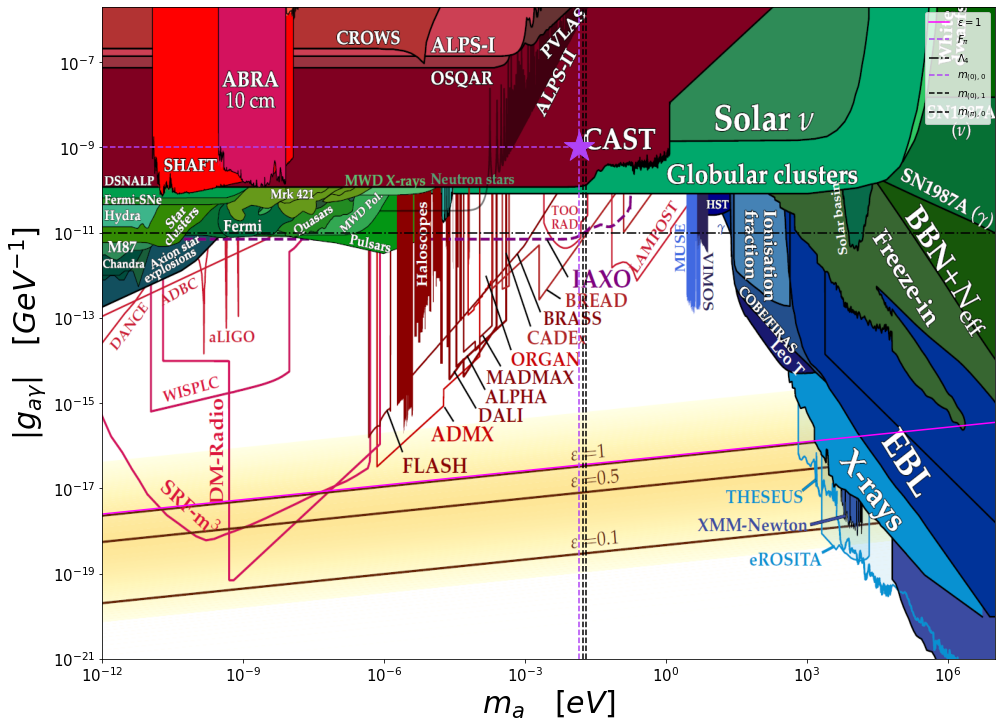

In [18]:
plt = plot_ALP_survey(verbosity=verbosity)

result_plots['alp'] = plt.gcf()
    
plt.show()

In [19]:
fit_eps = False
if fit_eps:
    pts = [(0.1,-19.9), (0.5,-18.6), (1,-17.9)]
    fit_res = fit_epsilon_relation(pts, plot_fit=True)
    if debug_level >= 0:
        print('y = %.3f log_10(10x + %.3f) + %.3f' % (fit_res[0], fit_res[1], fit_res[2]))

In [20]:
# Optionally save results of this run to data directory
save_input_params = True
save_integrations = True
save_output_plots = True
use_longterm_data = False

if save_output_files:
    storage_path = data_path if use_longterm_data else '~/scratch'
    output_dir   = '/'.join(storage_path.split('/')) + '/' + version + '/' + config_name + '/'
    output_name  = '_'.join([config_name, phash])
    
    save_results(output_dir, output_name, params, solutions, result_plots, verbosity=debug_level, save_format='pdf',
                 save_params=save_input_params, save_results=save_integrations, save_plots=save_output_plots)
    
    # Save plots (PDF or HTML or PNG or Notebook?)
    # (TODO)

Results saved to /users/sloane1/scratch/v2.6/3_neutrals/
Files saved:                                                       | (Total: 437.2KiB)
  3_neutrals_c2cbe8aba291239f8602f532e6f0b52a4e3c15a1.json         | 2.8KiB
  3_neutrals_c2cbe8aba291239f8602f532e6f0b52a4e3c15a1.npy          | 31.4KiB
  3_neutrals_c2cbe8aba291239f8602f532e6f0b52a4e3c15a1_plots.pdf    | 402.9KiB
